# 농산물 가격 및 기상 데이터 분석 및 시각화

## 1. 라이브러리 임포트

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # 스케일링을 위해 추가

# 한글 폰트 설정 (Windows 환경)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False # 마이너스 폰트 깨짐 방지

## 2. 데이터 로드 및 초기 탐색

In [49]:
# 파일 경로
price_file = './data/region_price.xlsx'
weather_file = './data/region_weather.csv'
cold_file = './data/mon_cold.xlsx'
hot_file = './data/mon_hot.xlsx'
wind_file = './data/mon_wind.xlsx'
export_import_file = './data/spinach_cucumber_df.xlsx'

# 데이터 로드
df_price = pd.read_excel(price_file)
df_weather = pd.read_csv(weather_file)
df_cold = pd.read_excel(cold_file)
df_hot = pd.read_excel(hot_file)
df_wind = pd.read_excel(wind_file)
df_ex_import = pd.read_excel(export_import_file)


# 각 데이터프레임 확인
print("\n--- 가격 데이터 (df_price) ---")
print(df_price.head(2))
print("\n--- 날씨 데이터 (df_weather) ---")
print(df_weather.head(2))
print("\n--- 한파 데이터 (df_cold) ---")
print(df_cold.head(2))
print("\n--- 폭염 데이터 (df_hot) ---")
print(df_hot.head(2))
print("\n--- 태풍 데이터 (df_wind) ---")
print(df_wind.head(2))
print("\n--- 수출입 데이터 (df_wi) ---")
print(df_ex_import.head(2))


--- 가격 데이터 (df_price) ---
    지역       날짜  품목          평균가격      총거래물량
0  강원도  2021-01  감자  24245.289659  3012880.0
1  경기도  2021-01  감자  24006.188904   356360.0

--- 날씨 데이터 (df_weather) ---
    지역       날짜  평균기온(°C)  월합강수량(00~24h만)(mm)  평균풍속(m/s)  최심적설(cm)
0  강원도  2019-01 -1.857143            4.678571   1.714286      17.1
1  강원도  2019-02  0.585714           22.928571   1.614286      17.1

--- 한파 데이터 (df_cold) ---
    지역  2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  2021-11  \
0  경기도        0        1        1        0        0        0        0   
1  강원도        0        1        1        1        0        0        0   

   2021-12  2022-01  ...  2023-12  2024-01  2024-02  2024-03  2024-04  \
0        1        1  ...        1        1        0        0        0   
1        1        1  ...        1        1        0        0        0   

   2024-11  2024-12  2025-01  2025-02  2025-03  
0        0        0        1        1        0  
1        0        1        1        1       

## 3. 데이터 전처리

In [50]:
# 날짜 컬럼을 datetime 형식으로 변환
df_price["날짜"] = pd.to_datetime(df_price["날짜"])
df_weather["날짜"] = pd.to_datetime(df_weather["날짜"])
df_ex_import["날짜"] = pd.to_datetime(df_ex_import["날짜"])

# 가격 데이터의 "평균가격"과 "총거래물량" 컬럼을 숫자형으로 변환
df_price["평균가격"] = pd.to_numeric(df_price["평균가격"], errors="coerce")
df_price["총거래물량"] = pd.to_numeric(df_price["총거래물량"], errors="coerce")

# 날씨 데이터 컬럼명 정리
weather_cols = ["지역", "날짜", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]

def preprocess_event_df(df, event_name):
    # 첫 번째 컬럼을 "지역"으로 설정하고 나머지 컬럼은 날짜로 간주
    df_melted = df.melt(id_vars=[df.columns[0]], var_name="날짜", value_name=f"{event_name}_발생")
    df_melted.rename(columns={df.columns[0]: "지역"}, inplace=True)
    # YYYY-MM 형식의 날짜를 datetime으로 변환 후 월 단위로 통일
    df_melted["날짜"] = pd.to_datetime(df_melted["날짜"], format="%Y-%m")
    df_melted["날짜"] = df_melted["날짜"].dt.to_period('M')
    return df_melted

df_cold_processed = preprocess_event_df(df_cold, "한파")
df_hot_processed = preprocess_event_df(df_hot, "폭염")
df_wind_processed = preprocess_event_df(df_wind, "태풍")

print("\n--- 전처리된 한파 데이터 (df_cold_processed) ---")
print(df_cold_processed.head())
print("\n--- 전처리된 폭염 데이터 (df_hot_processed) ---")
print(df_hot_processed.head())
print("\n--- 전처리된 태풍 데이터 (df_wind_processed) ---")
print(df_wind_processed.head())


--- 전처리된 한파 데이터 (df_cold_processed) ---
     지역       날짜  한파_발생
0   경기도  2020-11      0
1   강원도  2020-11      0
2  전라남도  2020-11      0
3  경상남도  2020-11      0
4  경상북도  2020-11      0

--- 전처리된 폭염 데이터 (df_hot_processed) ---
     지역       날짜  폭염_발생
0   경기도  2020-06      1
1   강원도  2020-06      1
2  전라남도  2020-06      1
3  경상남도  2020-06      1
4  경상북도  2020-06      1

--- 전처리된 태풍 데이터 (df_wind_processed) ---
        지역       날짜  태풍_발생
0  제주특별자치도  2020-08      1
1      강원도  2020-08      1
2     전라남도  2020-08      1
3     경상남도  2020-08      1
4    광주광역시  2020-08      1


## 4. 가격 및 날씨 데이터 통합

In [51]:
# 날짜 월 단위 통일
df_weather["날짜"] = df_weather["날짜"].dt.to_period('M')

# 날짜 월 단위 통일
df_price["날짜"] = df_price["날짜"].dt.to_period('M')

# 날짜 월 단위 통일
df_ex_import["날짜"] = df_ex_import["날짜"].dt.to_period('M')

# 가격 데이터와 날씨 데이터를 병합
merged_df = pd.merge(df_price, df_weather, left_on=["지역", "날짜"], right_on=["지역", "날짜"], how="left")

# 이벤트 데이터 병합
merged_df = pd.merge(merged_df, df_cold_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_hot_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_wind_processed, on=["지역", "날짜"], how="left")

# 최심적설, 한파, 폭염, 태풍의 NaN 값은 0으로 fill
merged_df["최심적설(cm)"] = merged_df["최심적설(cm)"].fillna(0)
merged_df["한파_발생"] = merged_df["한파_발생"].fillna(0)
merged_df["폭염_발생"] = merged_df["폭염_발생"].fillna(0)
merged_df["태풍_발생"] = merged_df["태풍_발생"].fillna(0)

# 숫자형 재변환하고, 변환할 수 없는 행 제거
numeric_cols = ["평균가격", "총거래물량", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
merged_df.dropna(subset=numeric_cols, inplace=True)

# 시금치, 오이에 대한 수출입물량 컬럼 추가
mini_df = merged_df[merged_df['품목'].isin(['시금치', '오이'])]
add_date = pd.merge(mini_df, df_ex_import, on=['날짜', '품목'], how='left')

print("병합된 데이터")
add_date.info()

병합된 데이터
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   지역                  1616 non-null   object   
 1   날짜                  1616 non-null   period[M]
 2   품목                  1616 non-null   object   
 3   평균가격                1616 non-null   float64  
 4   총거래물량               1616 non-null   float64  
 5   평균기온(°C)            1616 non-null   float64  
 6   월합강수량(00~24h만)(mm)  1616 non-null   float64  
 7   평균풍속(m/s)           1616 non-null   float64  
 8   최심적설(cm)            1616 non-null   float64  
 9   한파_발생               1616 non-null   float64  
 10  폭염_발생               1616 non-null   float64  
 11  태풍_발생               1616 non-null   float64  
 12  수입중량                1616 non-null   float64  
 13  수출중량                1616 non-null   float64  
dtypes: float64(11), object(2), period[M](1)
memory usage: 176.9+ KB


## 5. 이상치 탐지 및 제거 (평균가격, 총거래물량)

In [52]:
def remove_outliers_iqr(df, column):
    # 결측값은 먼저 제거
    df = df[df[column].notna()]

    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ["평균가격", "총거래물량"]
original_rows = len(add_date)

# 1. 결측값 제거 후 이상치 제거
if "평균가격" in add_date.columns:
    add_date = add_date[add_date["평균가격"].notna()]
    add_date = remove_outliers_iqr(add_date, "평균가격")
    print(f"컬럼 평균가격에서 이상치 제거 후 데이터 크기: {len(add_date)}")

# 2. 결측값 평균으로 대체
if "총거래물량" in add_date.columns:
    mean_value = add_date["총거래물량"].mean()
    add_date["총거래물량"].fillna(mean_value, inplace=True)

print(f"\n총 {original_rows - len(add_date)}개 행 제거")
add_date.describe()

컬럼 평균가격에서 이상치 제거 후 데이터 크기: 1616

총 0개 행 제거


C:\Users\mjs\AppData\Local\Temp\ipykernel_12916\1871925706.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  add_date["총거래물량"].fillna(mean_value, inplace=True)


,평균가격,총거래물량,평균기온(°C),월합강수량(00~24h만)(mm),평균풍속(m/s),최심적설(cm),한파_발생,폭염_발생,태풍_발생,수입중량,수출중량
count,1616.000000,1.616000e+03,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1.616000e+03,1616.000000
mean,19384.284808,2.040110e+05,13.543440,109.283662,1.944979,1.573267,0.103960,0.217822,0.112005,9.598275e+05,7374.327376
std,11319.835060,3.999277e+05,9.237562,115.052278,0.631677,4.833266,0.305304,0.412893,0.315470,7.081669e+05,13960.860232
min,1300.000000,4.000000e+00,-4.600000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,5.970000e+04,12.000000
25%,10323.701683,9.338000e+03,5.826786,31.100000,1.435714,0.000000,0.000000,0.000000,0.000000,2.561200e+05,412.500000
50%,16284.305970,3.993600e+04,14.360714,80.200000,1.800000,0.000000,0.000000,0.000000,0.000000,1.174982e+06,3630.150000
75%,26046.780174,1.704675e+05,22.353846,141.357143,2.400000,0.000000,0.000000,0.000000,0.000000,1.606030e+06,11308.650000
max,70170.009341,2.942760e+06,29.300000,776.300000,4.300000,50.600000,1.000000,1.000000,1.000000,2.213432e+06,130380.900000


## 6. 스케일링

In [53]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['평균가격', '총거래물량', '평균기온(°C)', '월합강수량(00~24h만)(mm)', '평균풍속(m/s)', '최심적설(cm)', '수입중량', '수출중량']

add_date[num_cols] = scaler.fit_transform(add_date[num_cols])

add_date.info()

# MinMaxScaler 
# from sklearn.preprocessing import MinMaxScaler

# numeric_cols = ['평균가격', '총거래물량', '평균기온(°C)', '월합강수량(00~24h만)(mm)', '평균풍속(m/s)', '최심적설(cm)', '한파_발생', '폭염_발생', '태풍_발생', '수입중량', '수출중량']
# df_scaled = add_date.copy()
# scaler = MinMaxScaler()
# df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   지역                  1616 non-null   object   
 1   날짜                  1616 non-null   period[M]
 2   품목                  1616 non-null   object   
 3   평균가격                1616 non-null   float64  
 4   총거래물량               1616 non-null   float64  
 5   평균기온(°C)            1616 non-null   float64  
 6   월합강수량(00~24h만)(mm)  1616 non-null   float64  
 7   평균풍속(m/s)           1616 non-null   float64  
 8   최심적설(cm)            1616 non-null   float64  
 9   한파_발생               1616 non-null   float64  
 10  폭염_발생               1616 non-null   float64  
 11  태풍_발생               1616 non-null   float64  
 12  수입중량                1616 non-null   float64  
 13  수출중량                1616 non-null   float64  
dtypes: float64(11), object(2), period[M](1)
memory usage: 176.9+ KB


## 7. EDA

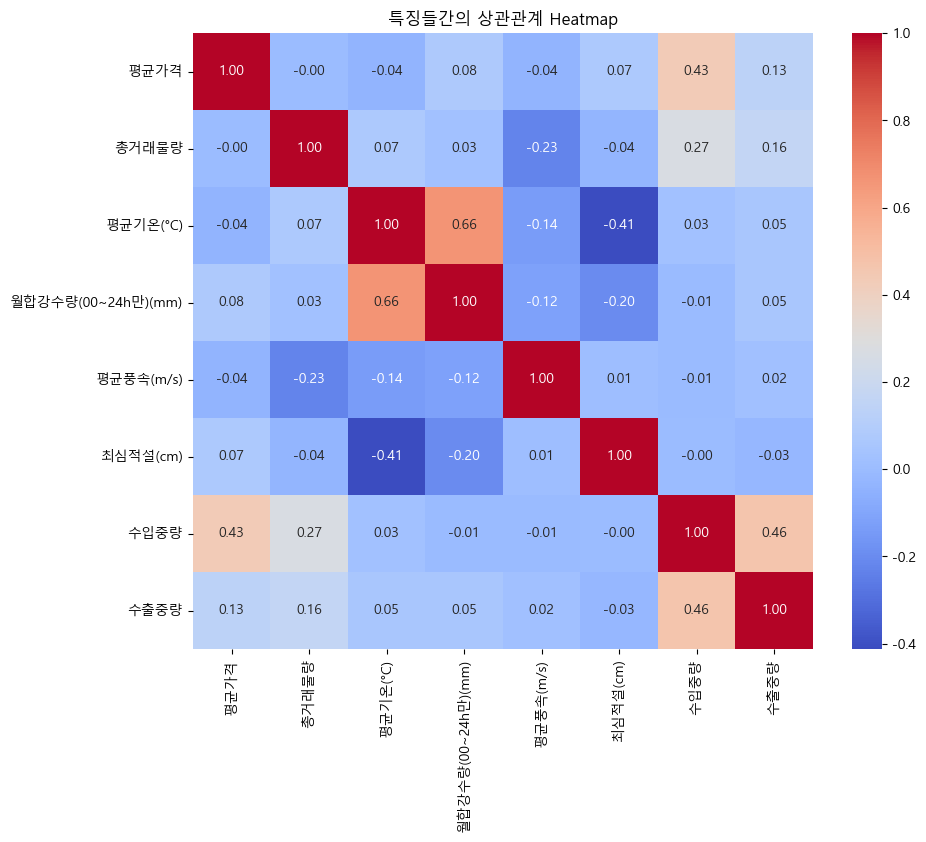

In [ ]:
# 특징들간의 상관관계 히스토그램
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

corr = add_date[num_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('특징들간의 상관관계 Heatmap')
plt.show()

<Axes: xlabel='월', ylabel='평균가격'>

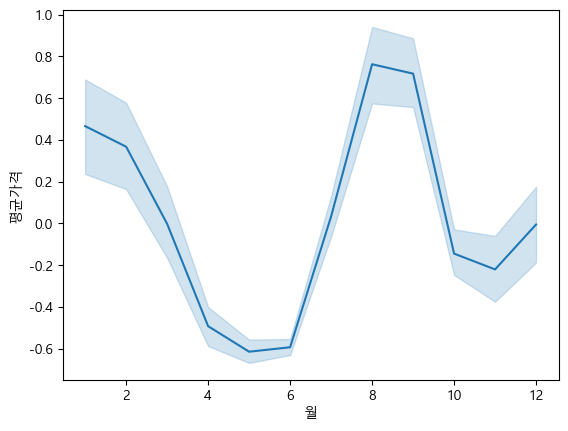

In [ ]:
# 가격의 계절성 확인
add_date['월'] = add_date['날짜'].dt.month
sns.lineplot(x='월', y='평균가격', data=add_date)

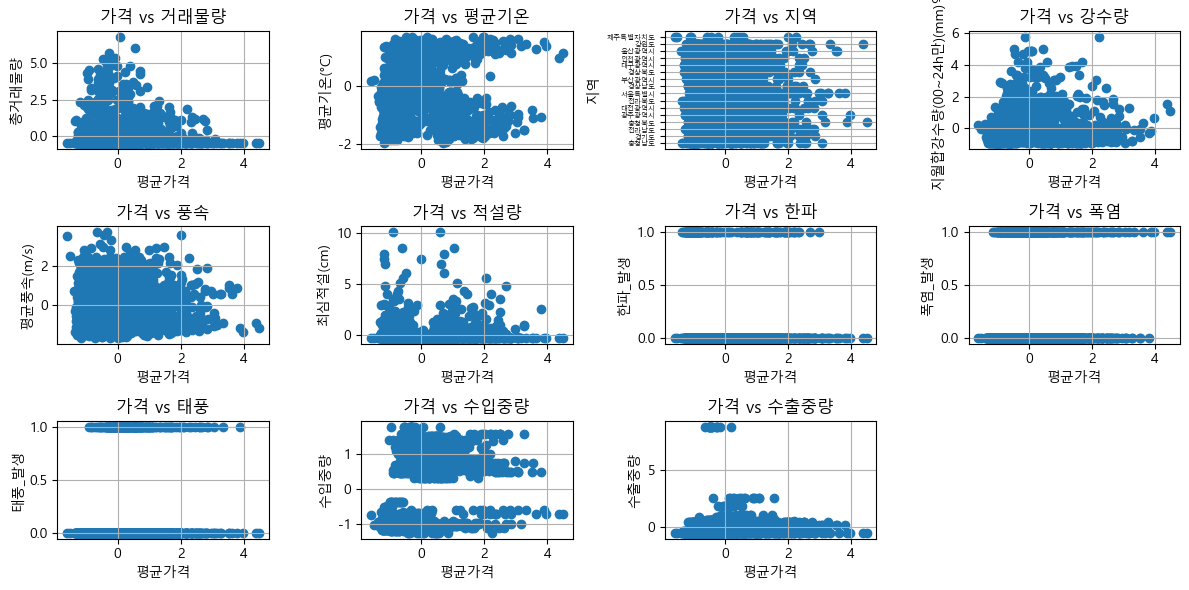

In [75]:
# 가격과 각 특징들 간의 관계 - 12개 (품목 제외)

plt.figure(figsize=(12, 6))

plt.subplot(3, 4, 1)
plt.scatter(add_date['평균가격'], add_date['총거래물량'])
plt.xlabel('평균가격')
plt.ylabel('총거래물량')
plt.title('가격 vs 거래물량')
plt.grid(True)

plt.subplot(3, 4, 2)
plt.scatter(add_date['평균가격'], add_date['평균기온(°C)'])
plt.xlabel('평균가격')
plt.ylabel('평균기온(°C)')
plt.title('가격 vs 평균기온')
plt.grid(True)

plt.subplot(3, 4, 3)
plt.scatter(add_date['평균가격'], add_date['지역'])
plt.xlabel('평균가격')
plt.ylabel('지역')
plt.yticks(fontsize=5)
plt.title('가격 vs 지역')
plt.grid(True)

plt.subplot(3, 4, 4)
plt.scatter(add_date['평균가격'], add_date['월합강수량(00~24h만)(mm)'])
plt.xlabel('평균가격')
plt.ylabel('지월합강수량(00~24h만)(mm)역')
plt.title('가격 vs 강수량')
plt.grid(True)

plt.subplot(3, 4, 5)
plt.scatter(add_date['평균가격'], add_date['평균풍속(m/s)'])
plt.xlabel('평균가격')
plt.ylabel('평균풍속(m/s)')
plt.title('가격 vs 풍속')
plt.grid(True)

plt.subplot(3, 4, 6)
plt.scatter(add_date['평균가격'], add_date['최심적설(cm)'])
plt.xlabel('평균가격')
plt.ylabel('최심적설(cm)')
plt.title('가격 vs 적설량')
plt.grid(True)

plt.subplot(3, 4, 7)
plt.scatter(add_date['평균가격'], add_date['한파_발생'])
plt.xlabel('평균가격')
plt.ylabel('한파_발생')
plt.title('가격 vs 한파')
plt.grid(True)

plt.subplot(3, 4, 8)
plt.scatter(add_date['평균가격'], add_date['폭염_발생'])
plt.xlabel('평균가격')
plt.ylabel('폭염_발생')
plt.title('가격 vs 폭염')
plt.grid(True)

plt.subplot(3, 4, 9)
plt.scatter(add_date['평균가격'], add_date['태풍_발생'])
plt.xlabel('평균가격')
plt.ylabel('태풍_발생')
plt.title('가격 vs 태풍')
plt.grid(True)

plt.subplot(3, 4, 10)
plt.scatter(add_date['평균가격'], add_date['수입중량'])
plt.xlabel('평균가격')
plt.ylabel('수입중량')
plt.title('가격 vs 수입중량')
plt.grid(True)

plt.subplot(3, 4, 11)
plt.scatter(add_date['평균가격'], add_date['수출중량'])
plt.xlabel('평균가격')
plt.ylabel('수출중량')
plt.title('가격 vs 수출중량')
plt.grid(True)

plt.tight_layout()
plt.show()

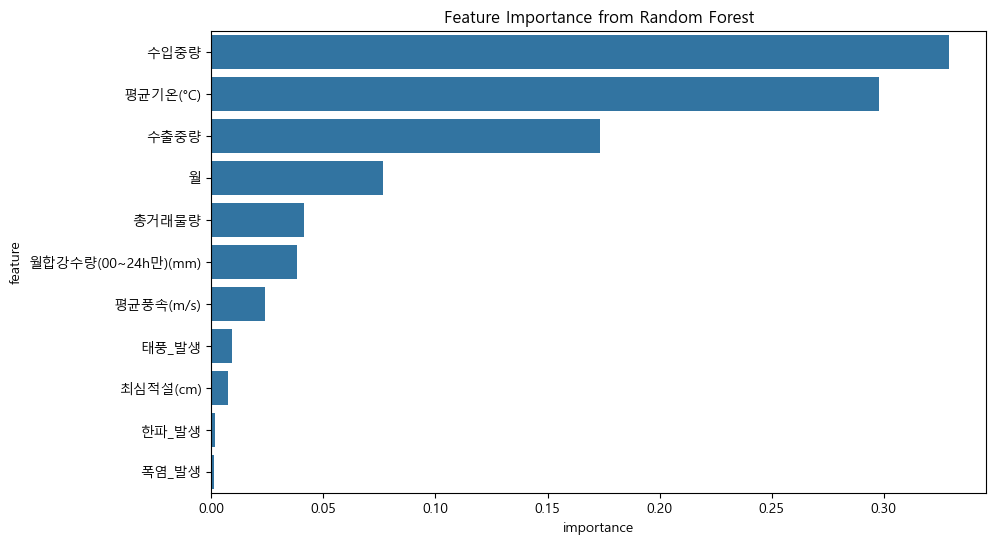

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = add_date.drop(columns=['평균가격', '지역', '날짜', '품목'])  # 범주형 열 제외
y = add_date['평균가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 피처 중요도
importances = model.feature_importances_
feat_names = X.columns

import pandas as pd
feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x='importance', y='feature')
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = df_encoded.drop(['평균가격', '날짜'], axis=1)  # 필요시 '날짜' 제외
y = df_encoded['평균가격']

# 학습용 / 테스트용 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, lr_pred)
r2_lr = r2_score(y_test, lr_pred)

print(f'\n✅ 선형 회귀 결과\nMSE: {mse_lr:.2f}, RMSE: {np.sqrt(mse_lr):.2f}, R²: {r2_lr:.4f}')


In [ ]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f"\n✅ 교차검증 R² 점수: {cv_scores}")
print(f"평균 R²: {cv_scores.mean():.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.title('실제 vs 예측 가격')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()
